# Droplets

This is based on the lesson 1 notebook of fastai course v3.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai.vision import *

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
bs = 16
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

In [4]:
path = Path('/home/jupyter/tutorials/data/droplets')

In [5]:
path.ls()

[PosixPath('/home/jupyter/tutorials/data/droplets/.ipynb_checkpoints'),
 PosixPath('/home/jupyter/tutorials/data/droplets/train')]

In [6]:
path_img = path/'train'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

In [7]:
fnames_bad = get_image_files(path_img/'bad')
fnames_good = get_image_files(path_img/'good')

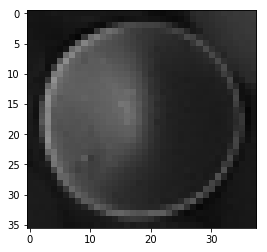

In [8]:
plt.imshow(plt.imread(str(fnames_bad[3])))

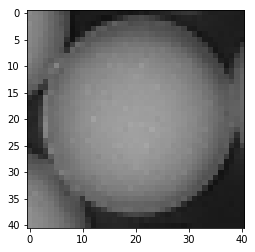

In [9]:
plt.imshow(plt.imread(str(fnames_good[3])))

In [10]:
get_transforms?

In [44]:
# this can include the test set
tfms = get_transforms(do_flip=True, 
                      max_zoom=1.0, 
                      max_lighting=None,
                      max_warp=None) # do_flip=True by default. 
data = ImageDataBunch.from_folder(path=path_img, # path to all the train/valid images
                                   valid_pct=0.15, # hold out percentage for validation
                                   ds_tfms=tfms, 
                                   bs=bs, 
                                   size=229).normalize(imagenet_stats)

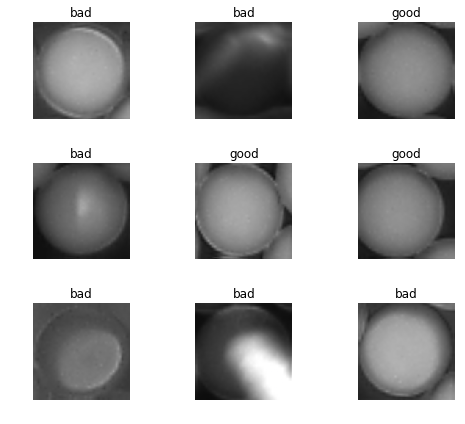

In [12]:
data.show_batch(rows=3, figsize=(7,6))

In [18]:
print(data.classes)
len(data.classes),data.c

['bad', 'good']


(2, 2)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 12 outputs).

We will train for 16 epochs (16 cycles through all our data).

In [45]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [47]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate
1,0.164912,0.262399,0.142857
2,0.116909,0.191233,0.142857
3,0.097578,0.128022,0.000000
4,0.093180,0.095834,0.000000
5,0.089097,0.073082,0.000000
6,0.091438,0.080815,0.000000


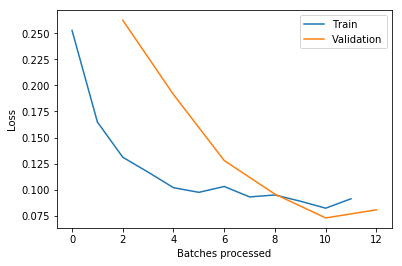

In [48]:
learn.recorder.plot_losses()

In [52]:
learn.save('droplets_resnet34_simple')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [53]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

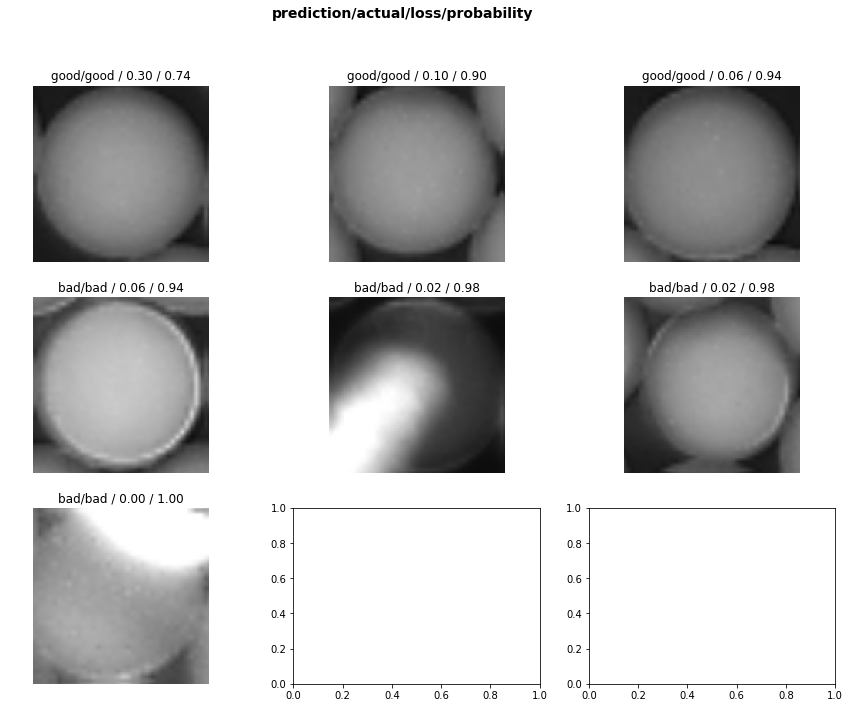

In [57]:
interp.plot_top_losses(7, figsize=(15,11))

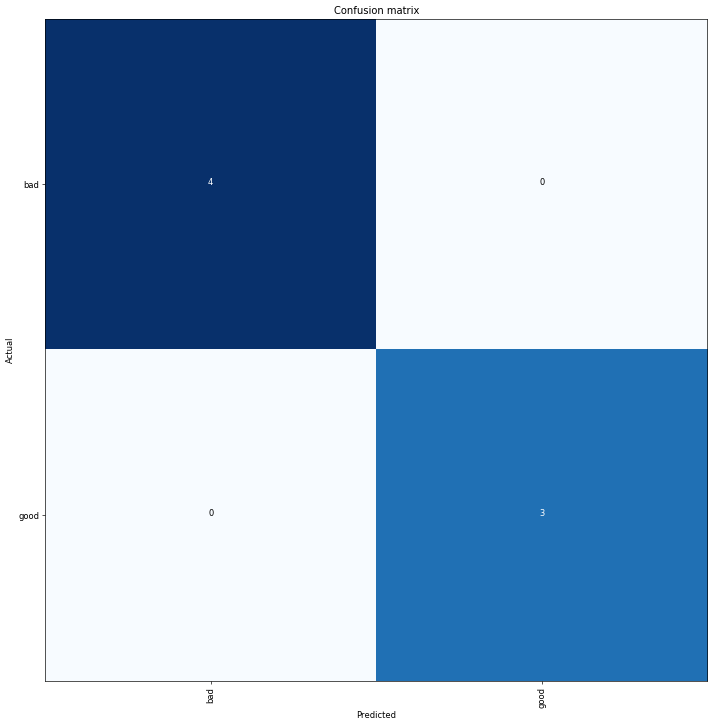

In [56]:
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

## Summary 20190331

* Setup of model
  * Need to be careful with transforms allowed in the model. Allowing unphysical transforms (such as lighting, warp or zoom) will make the model worse
  * valid pct tested: 0.1, 0.15 and 0.2. With 0.1 and 0.15, validation accuracy could be 100%
  * with so few images, need to monitor overfitting
* Next
  * Get more images

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [28]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.193083,1.356048,0.400000


In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


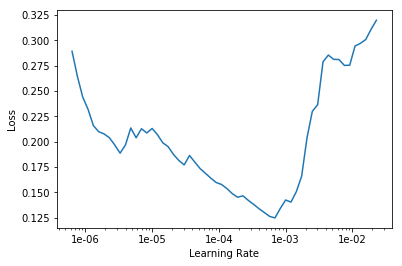

In [31]:
learn.recorder.plot()

In [32]:
learn.unfreeze()
learn.fit_one_cycle(16, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.230339,1.288870,0.200000
2,0.124386,1.163652,0.200000
3,0.121762,1.229467,0.200000
4,0.108279,1.152851,0.200000
5,0.112929,0.977487,0.200000
6,0.106329,0.955109,0.200000
7,0.125890,0.876603,0.200000
8,0.131154,0.793774,0.200000
9,0.120622,0.666076,0.200000
10,0.115998,0.529369,0.200000


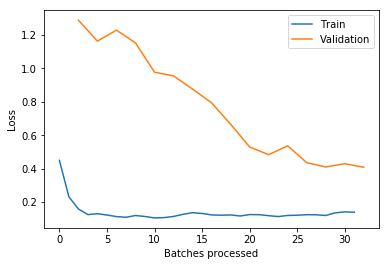

In [33]:
learn.recorder.plot_losses()

In [34]:
learn.save('droplet_resnet34_unfreeze')

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [35]:
# this can include the test set
tfms = get_transforms(do_flip=True) # do_flip=True by default. 
data2 = ImageDataBunch.from_folder(path=path_img, # path to all the train/valid images
                                   test='../test',
                                   valid_pct=0.1, # hold out 20% for validation
                                   ds_tfms=tfms, 
                                   bs=bs, 
                                   size=299).normalize(imagenet_stats)

In [36]:
learn50 = create_cnn(data2, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


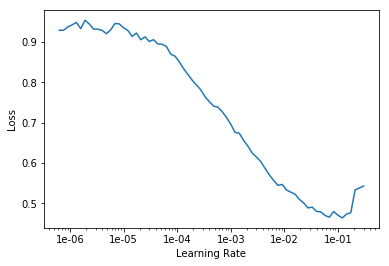

In [37]:
learn50.lr_find()
learn50.recorder.plot()

In [38]:
learn50.fit_one_cycle(16, max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.914871,0.664675,0.400000
2,0.626499,1.681531,0.400000
3,0.519716,2.431505,0.400000
4,0.511320,3.055310,0.400000
5,0.428280,2.821828,0.400000
6,0.377654,2.100810,0.200000
7,0.387479,1.753012,0.200000
8,0.381968,1.277394,0.200000
9,0.340809,0.963462,0.200000
10,0.307271,0.726650,0.200000


Without unfreezing, the lowest error rate is about 0.054.

In [39]:
learn50.save('droplets-resnet50-simple')

In [40]:
learn50.load('droplets-resnet50-simple')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (47 items)
[Category bad, Category bad, Category bad, Category bad, Category bad]...
Path: /home/jupyter/tutorials/data/droplets/train
x: ImageItemList (47 items)
[Image (3, 36, 37), Image (3, 38, 36), Image (3, 36, 38), Image (3, 38, 40), Image (3, 38, 40)]...
Path: /home/jupyter/tutorials/data/droplets/train;

Valid: LabelList
y: CategoryList (5 items)
[Category bad, Category good, Category bad, Category good, Category bad]...
Path: /home/jupyter/tutorials/data/droplets/train
x: ImageItemList (5 items)
[Image (3, 39, 37), Image (3, 39, 37), Image (3, 36, 38), Image (3, 40, 41), Image (3, 55, 51)]...
Path: /home/jupyter/tutorials/data/droplets/train;

Test: LabelList
y: CategoryList (0 items)
[]...
Path: /home/jupyter/tutorials/data/droplets/train
x: ImageItemList (0 items)
[]...
Path: /home/jupyter/tutorials/data/droplets/train, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2),

In [41]:
learn50.unfreeze()
learn50.fit_one_cycle(16, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.094048,0.627062,0.200000
2,0.104676,0.550319,0.200000
3,0.081627,0.625677,0.400000
4,0.147770,0.846977,0.200000
5,0.127775,1.114590,0.400000
6,0.111136,1.578161,0.200000
7,0.095845,2.150638,0.200000
8,0.098020,3.244253,0.200000
9,0.090883,3.694680,0.200000
10,0.083838,3.026942,0.200000


In [42]:
learn50.save('seedling_resnet50-unfreeze');

not bad. although not as good as the first epoch from the previous run.

In [43]:
interp = ClassificationInterpretation.from_learner(learn50)

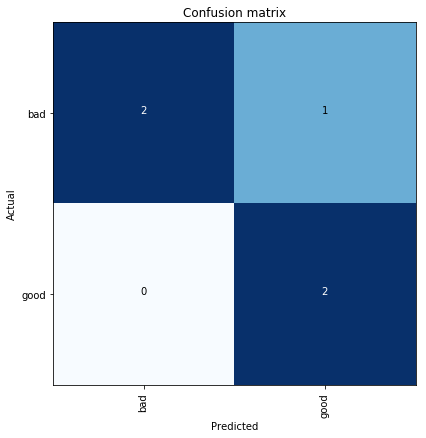

In [45]:
interp.plot_confusion_matrix(figsize=(6,6))

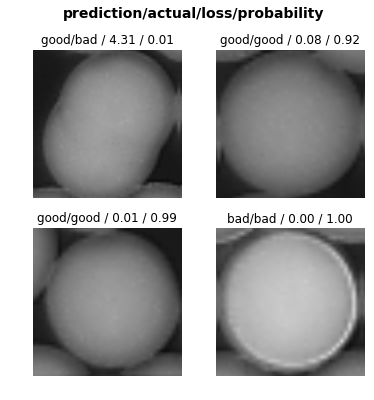

In [46]:
interp.plot_top_losses(4, figsize=(6,6))